In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt

In [2]:
xls = pd.ExcelFile('science.adg8488_data_s1.xlsx')

In [3]:
xls.sheet_names

['Info',
 'Time-ser',
 'P-B',
 'Growth',
 'Mortality',
 'SAD',
 'Mean-var',
 'Density',
 'Size-spec',
 'Group']

In [4]:
pbdf = xls.parse('P-B')

In [5]:
pbdf.columns

Index(['Unique_ID', 'Taxa', 'Ecosystem', 'x_gm', 'y_gm', 'Reference', 'Group',
       'Lat', 'Lon', 'Year', 'Plot_name', 'Notes'],
      dtype='object')

In [6]:
groups = pbdf['Plot_name'].unique()
groups = [g for g in groups if g == g]  # remove nan
names = [g.split(' production')[0] for g in groups]
num_groups = len(groups)
num_groups

21

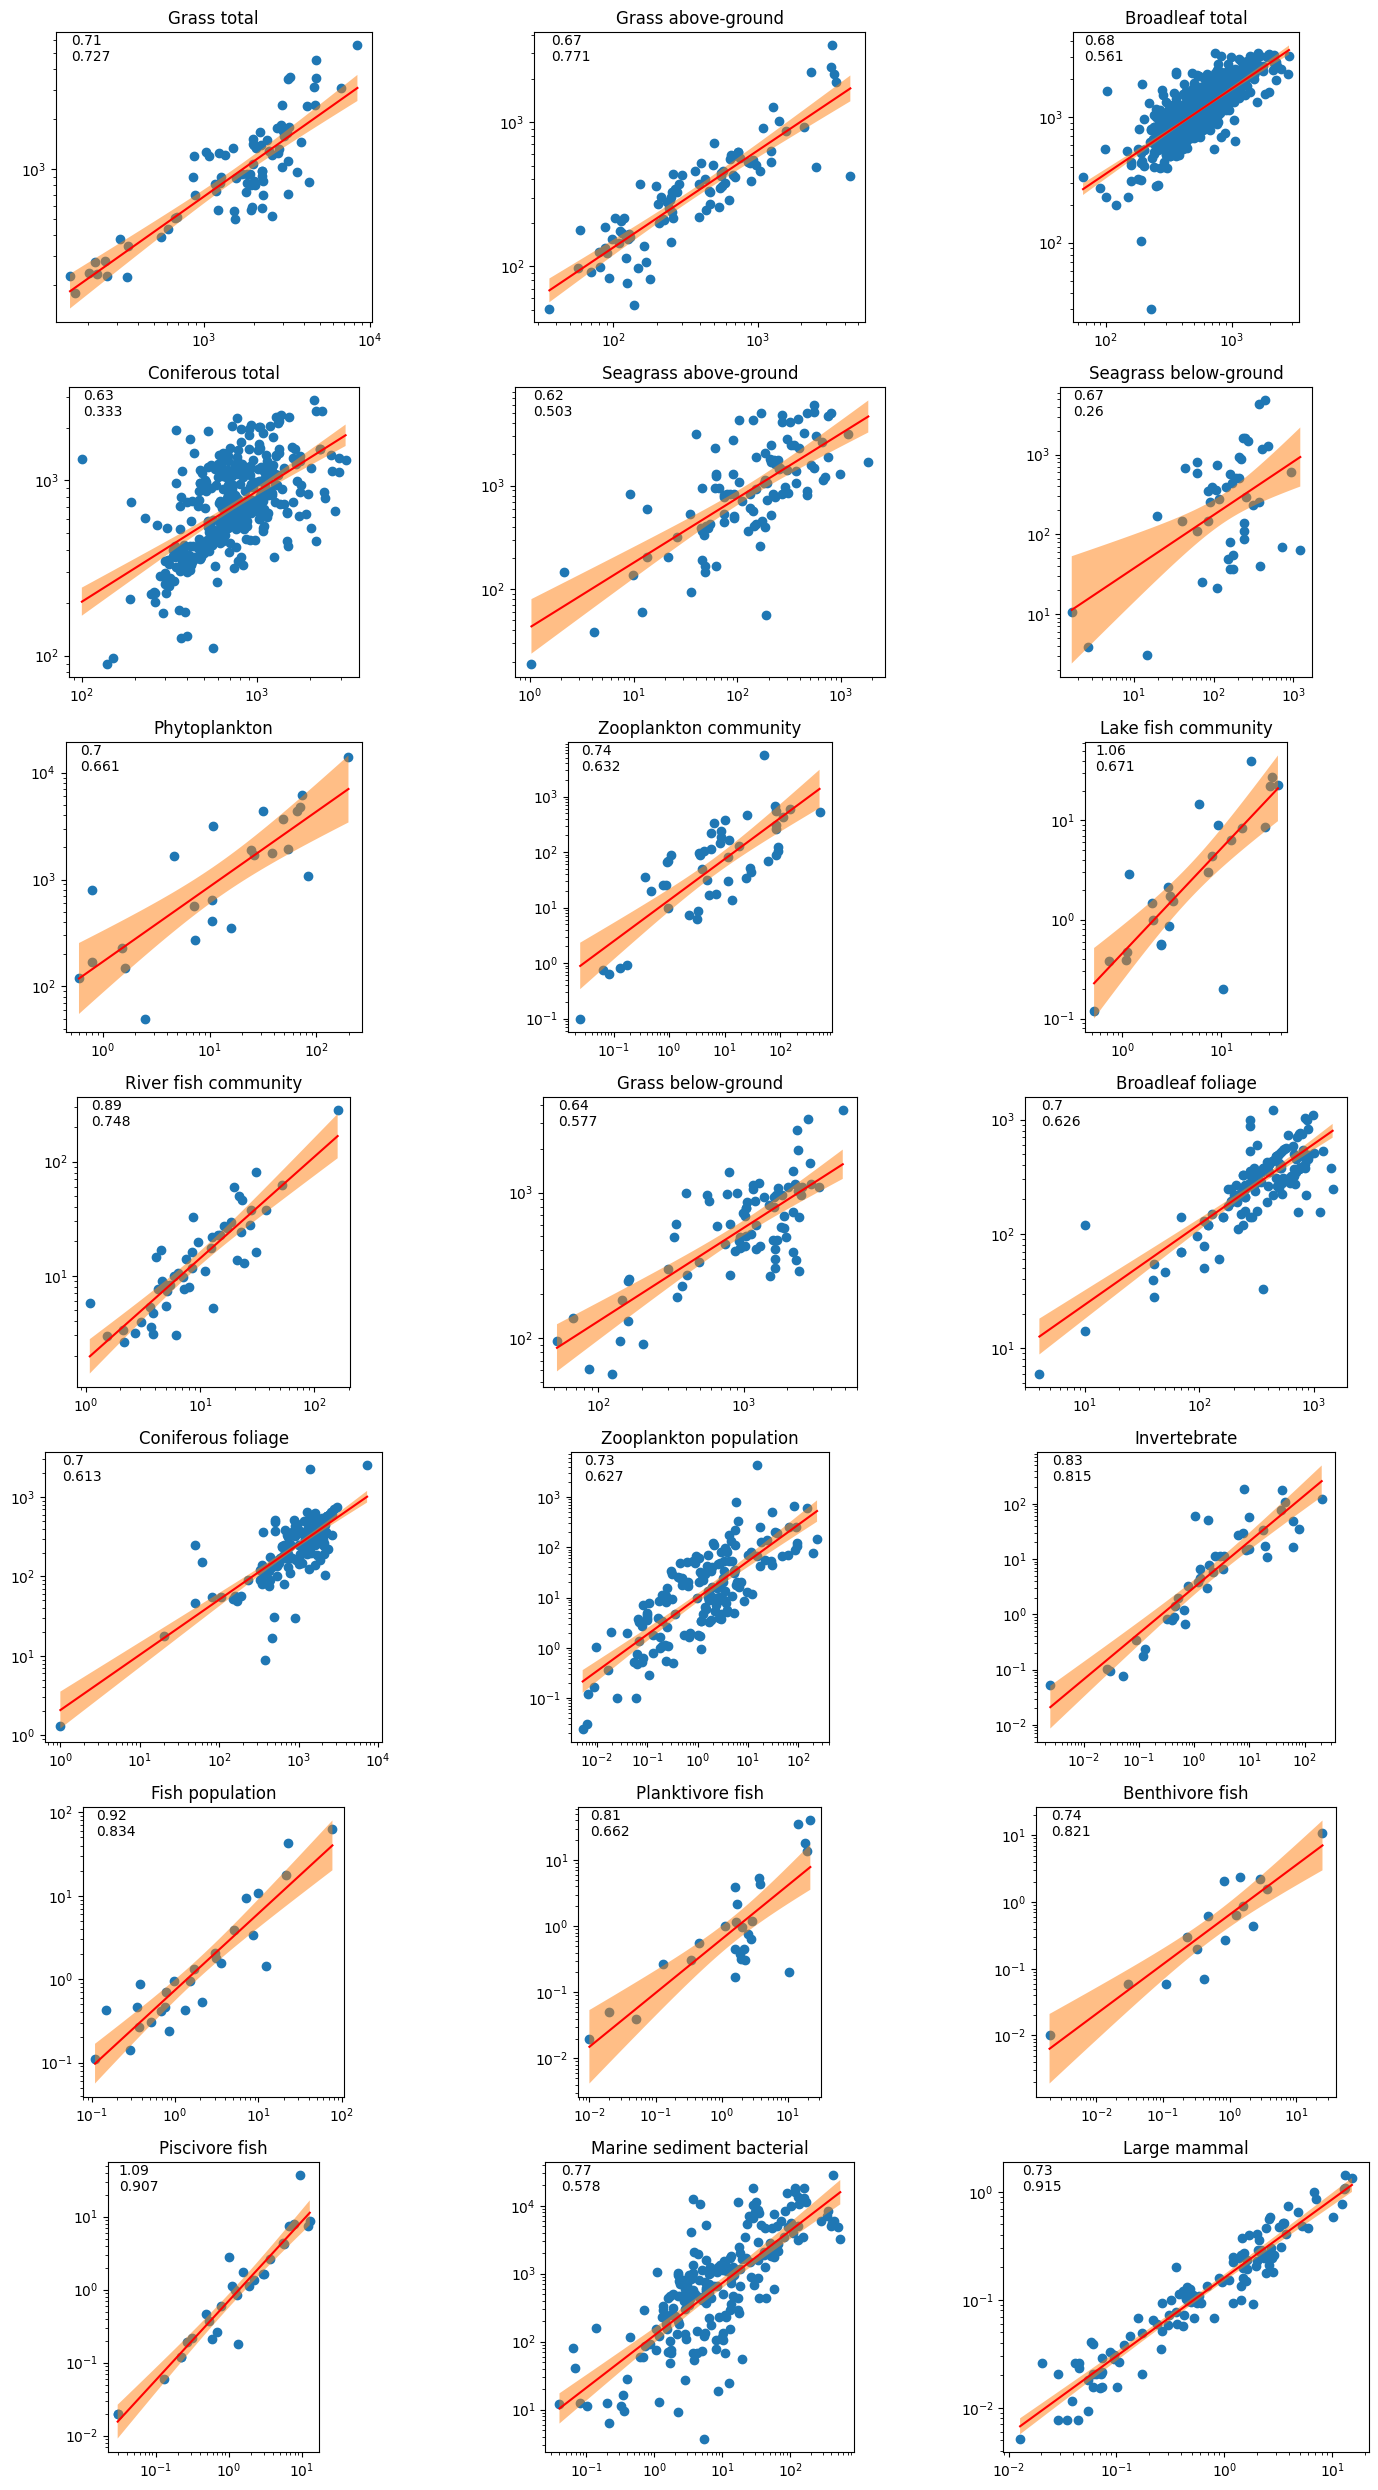

In [73]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import linregress

fig, axs = plt.subplots(7, 3, figsize=(15, 25))

for ax, g, n in zip(axs.flatten(), groups, names):
    cols = pbdf.loc[pbdf['Plot_name'] == g]
    xs = cols['x_gm']
    ys = cols['y_gm']
    ax.scatter(xs, ys)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set(aspect='equal')
    ax.set_title(n)

    # Perform log-log regression
    log_xs = np.log(xs)
    log_ys = np.log(ys)
    slope, intercept, r_value, p_value, std_err = linregress(log_xs, log_ys)

    alpha = 0.05  # 95% confidence interval
    X = sm.add_constant(log_xs)
    model = sm.OLS(log_ys, X).fit()

    # Generate predictions over a range of values
    log_X_pred = np.linspace(np.min(log_xs), np.max(log_xs), 100)
    X_pred_ = sm.add_constant(log_X_pred)

    # Predict log-mean values and confidence intervals
    log_y_pred = model.predict(X_pred_)
    predictions = model.get_prediction(X_pred_)
    prediction_summary = predictions.summary_frame(alpha=0.05)

    # Extract lower and upper confidence bounds in the log scale
    log_lower = prediction_summary['mean_ci_lower']
    log_upper = prediction_summary['mean_ci_upper']

    # Convert back to the original scale
    X_pred = np.exp(log_X_pred)
    y_pred = np.exp(log_y_pred)
    lower = np.exp(log_lower)
    upper = np.exp(log_upper)

    # Plot regression line and confidence intervals
    ax.plot(X_pred, y_pred, 'r-', label='Regression Line')
    ax.fill_between(X_pred, lower, upper, alpha=0.5, label='95% Confidence Interval')

    k = model.params.loc['x_gm']
    ax.text(0.05,0.9,f"{round(k,2)}\n{round(model.rsquared,3)}",transform=ax.transAxes)

plt.tight_layout()
plt.savefig("macoeco.png",bbox_inches="tight")
plt.show()



In [ ]:
prediction_summary

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,-5.001226,0.086068,-5.171694,-4.830758,-5.769223,-4.233229
1,-4.949195,0.084723,-5.117001,-4.781390,-5.716606,-4.181785
2,-4.897165,0.083384,-5.062316,-4.732013,-5.663999,-4.130330
3,-4.845134,0.082048,-5.007641,-4.682627,-5.611403,-4.078864
4,-4.793103,0.080718,-4.952975,-4.633232,-5.558818,-4.027388
...,...,...,...,...,...,...
95,-0.058311,0.070342,-0.197632,0.081009,-0.820001,0.703378
96,-0.006281,0.071625,-0.148142,0.135581,-0.768439,0.755878
97,0.045750,0.072915,-0.098666,0.190167,-0.716888,0.808388
98,0.097781,0.074211,-0.049204,0.244766,-0.665348,0.860909


In [69]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   y_gm   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     1249.
Date:                Thu, 30 May 2024   Prob (F-statistic):           6.06e-64
Time:                        14:49:20   Log-Likelihood:                -51.654
No. Observations:                 118   AIC:                             107.3
Df Residuals:                     116   BIC:                             112.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8316      0.036    -50.194      0.000      -1.904      -1.759
x_gm           0.7273      0.021     35.346      0.000       0.687       0.768
==============================================================================
Omnibus:                        0.354   Durbin-Watson:                   1.739
Prob(Omnibus):                  0.838   Jarque-Bera (JB):                0.201
Skew:                          -0.100   Prob(JB):                        0.904
Kurtosis:                       3.029   Cond. No.                         1.93
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [70]:
model.rsquared

0.9150397873196091